## 导入基础库

In [14]:
import os
import numpy as np
import nibabel as nib  # 用于读取 .nii 文件
import matplotlib.pyplot as plt

data_root = 'D:\\工程项目\\肝脏和肿瘤分割\\data'
 

image_dir = os.path.join(data_root, 'LiTS(train_test)', 'train_CT')
label_dir = os.path.join(data_root, 'LiTS(train_test)', 'train_mask')

print(f"图片目录: {image_dir}")
print(f"标签目录: {label_dir}")

图片目录: D:\工程项目\肝脏和肿瘤分割\data\LiTS(train_test)\train_CT
标签目录: D:\工程项目\肝脏和肿瘤分割\data\LiTS(train_test)\train_mask


## 读取一个病例

In [15]:
ind = 0
imf = f"volume-{ind}.nii"
laf = f"segmentation-{ind}.nii"

imp = os.path.join(image_dir, imf)
lap = os.path.join(label_dir, laf)

# 检查文件是否存在
if not os.path.exists(imp):
    print(f"找不到文件: {imp}")
    print("请检查上面的 image_dir 路径是否填写正确！")
else:
    print(f"找到文件: {imf}")

    # 加载 NIfTI 数据
    img_obj = nib.load(imp)
    lbl_obj = nib.load(lap)
    
    # 获取数据数组 (这是 numpy array)
    img_data = img_obj.get_fdata()
    lbl_data = lbl_obj.get_fdata()

    print(f"影像形状 (Shape): {img_data.shape}")
    print(f"影像数据类型: {img_data.dtype}")
    print(f"影像强度范围 (Min/Max): {np.min(img_data):.2f} / {np.max(img_data):.2f}")

    print(f"标签形状: {lbl_data.shape}")
    
    unique_labels = np.unique(lbl_data)   # np.unique 会列出数组里所有出现过的不重复数值
    print(f"标签里包含的数值 (Unique Values): {unique_labels}")

    # 解释
    if np.array_equal(unique_labels, [0, 1, 2]):
        print("验证成功！标签符合预期：0=背景, 1=肝脏, 2=肿瘤")
    else:
        print("注意：标签数值和预期不同，请记录下来！")

找到文件: volume-0.nii
影像形状 (Shape): (512, 512, 75)
影像数据类型: float64
影像强度范围 (Min/Max): -3024.00 / 1410.00
标签形状: (512, 512, 75)
标签里包含的数值 (Unique Values): [0. 1. 2.]
验证成功！标签符合预期：0=背景, 1=肝脏, 2=肿瘤


## 可视化切片

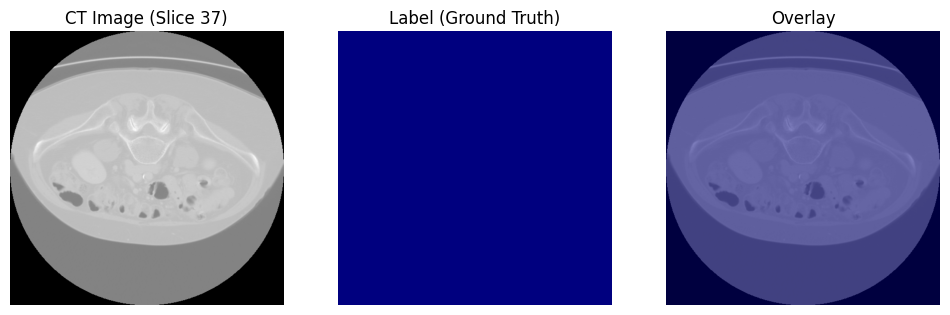

In [16]:
# 取 Z 轴中间的一层
slice_idx = img_data.shape[2] // 2

plt.figure(figsize=(12, 6))

# 显示 CT 原图
plt.subplot(1, 3, 1)
# CT 图片通常需要转置一下才符合人类直觉，加 .T 试试，如果倒了再改
plt.imshow(img_data[:, :, slice_idx].T, cmap='gray')
plt.title(f"CT Image (Slice {slice_idx})")
plt.axis('off')

# 显示 标签 (Mask)
plt.subplot(1, 3, 2)
plt.imshow(lbl_data[:, :, slice_idx].T, cmap='jet', interpolation='nearest')
plt.title("Label (Ground Truth)")
plt.axis('off')

# 显示 叠加图 (Overlay) - 这样能看出标注准不准
plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, slice_idx].T, cmap='gray')
plt.imshow(lbl_data[:, :, slice_idx].T, cmap='jet', alpha=0.5, interpolation='nearest') # alpha是透明度
plt.title("Overlay")
plt.axis('off')

plt.show()

发现肿瘤！肿瘤面积最大的一层是: Slice 58


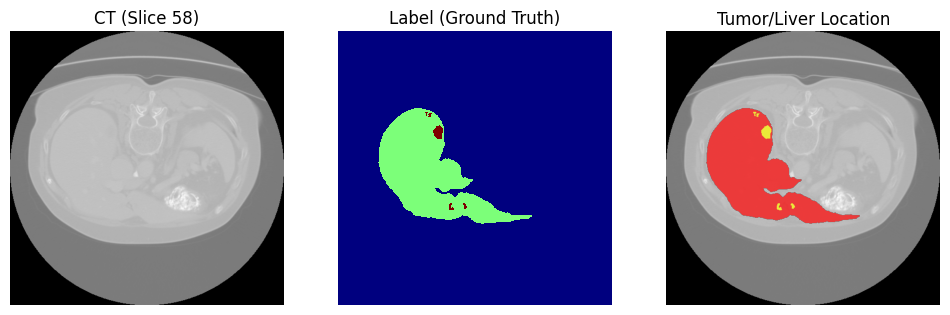

In [18]:
# 1. 寻找包含“肿瘤”像素最多的那一层
# 2 (肿瘤) 的像素数量在 Z 轴上的分布
tumor_counts = np.sum(lbl_data == 2, axis=(0, 1)) 

# 找到肿瘤像素最多的那一层的索引
max_tumor_slice = np.argmax(tumor_counts)

if tumor_counts[max_tumor_slice] == 0:
    print("这个病例好像没有肿瘤（或者标签里没标）！")
    # 如果没有肿瘤，我们就找肝脏(1)最多的那一层
    liver_counts = np.sum(lbl_data == 1, axis=(0, 1))
    max_tumor_slice = np.argmax(liver_counts)
    print(f"改为显示肝脏面积最大的一层: Slice {max_tumor_slice}")
else:
    print(f"发现肿瘤！肿瘤面积最大的一层是: Slice {max_tumor_slice}")

# 2. 重新画图
plt.figure(figsize=(12, 6))
slice_idx = max_tumor_slice

# CT
plt.subplot(1, 3, 1)
plt.imshow(img_data[:, :, slice_idx].T, cmap='gray')
plt.title(f"CT (Slice {slice_idx})")
plt.axis('off')

# Label
plt.subplot(1, 3, 2)
plt.imshow(lbl_data[:, :, slice_idx].T, cmap='jet', interpolation='nearest')
plt.title("Label (Ground Truth)")
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, slice_idx].T, cmap='gray')
# 创建一个透明度蒙版，只有有标签的地方才显示颜色
mask = np.ma.masked_where(lbl_data[:, :, slice_idx].T == 0, lbl_data[:, :, slice_idx].T)
plt.imshow(mask, cmap='autumn', alpha=0.7) # 用显眼的颜色
plt.title("Tumor/Liver Location")
plt.axis('off')

plt.show()

In [19]:
from monai.transforms import MapLabelValued
MapLabelValued?

Init signature:
MapLabelValued(
    keys: 'KeysCollection',
    orig_labels: 'Sequence',
    target_labels: 'Sequence',
    dtype: 'DtypeLike' = <class 'numpy.float32'>,
    allow_missing_keys: 'bool' = False,
) -> 'None'
Docstring:      Dictionary-based wrapper of :py:class:`monai.transforms.MapLabelValue`.
Init docstring:
Args:
    keys: keys of the corresponding items to be transformed.
        See also: :py:class:`monai.transforms.compose.MapTransform`
    orig_labels: original labels that map to others.
    target_labels: expected label values, 1: 1 map to the `orig_labels`.
    dtype: convert the output data to dtype, default to float32.
        if dtype is from PyTorch, the transform will use the pytorch backend, else with numpy backend.
    allow_missing_keys: don't raise exception if key is missing.
File:           d:\工程项目\肝脏和肿瘤分割\myvenv\lib\site-packages\monai\transforms\utility\dictionary.py
Type:           ABCMeta
Subclasses:     